In [1]:
# --- 1. SETUP AND DATA LOADING ---

# Import necessary libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive to access files
print("Connecting to Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive connected.")

# Define the file path to your data folder in Google Drive
# This path is now updated to your 'meesho' folder.
data_path = "/content/drive/MyDrive/meesho/"

# Create in-memory SQL databases
db1 = sqlite3.connect(':memory:') # For Sales Analysis
db2 = sqlite3.connect(':memory:') # For Retention Analysis
db3 = sqlite3.connect(':memory:') # For OTIF Analysis


Connecting to Google Drive...
Mounted at /content/drive
✅ Google Drive connected.


In [2]:
# --- 2. DATA PIPELINE: Load CSVs into SQL Tables ---

print("\nLoading data into databases...")
try:
    # Load Sales data
    pd.read_csv(data_path + 'orders.csv').to_sql('orders', db1, index=False)
    pd.read_csv(data_path + 'order_details.csv').to_sql('order_details', db1, index=False)
    pd.read_csv(data_path + 'products.csv').to_sql('products', db1, index=False)
    print("✅ Sales data loaded.")

    # Load Retention data
    pd.read_csv(data_path + 'q2_orders.csv').to_sql('orders', db2, index=False)
    print("✅ Retention data loaded.")

    # Load Operations data
    pd.read_csv(data_path + 'order_timeline.csv').to_sql('order_timeline', db3, index=False)
    pd.read_csv(data_path + 'order_shipment.csv').to_sql('order_shipment', db3, index=False)
    print("✅ Operations data loaded.")
except FileNotFoundError as e:
    print(f"\n❌ ERROR: Could not find a file. Please check that your folder is named 'meesho' and contains all 6 CSV files.")
    print(f"Details: {e}")

# Helper functions to run SQL queries
def run_query1(query): return pd.read_sql_query(query, db1)
def run_query2(query): return pd.read_sql_query(query, db2)
def run_query3(query): return pd.read_sql_query(query, db3)



Loading data into databases...
✅ Sales data loaded.
✅ Retention data loaded.
✅ Operations data loaded.




--- Part 1: Sales Analysis ---

[Analysis] Calculating GMV per Product...
                     product_name   GMV
0         Ethnic Oxidised Jhumkas  3998
1  Women's Floral Print Kurta Set  2998
2        Men's Casual Check Shirt  2499
3       Sassy Printed Phone Cover  2097
4     Kids' Graphic Print T-shirt  1798
5          Handwoven Cotton Saree  1299

[Analysis] Plotting Number of Orders vs. Product Price...


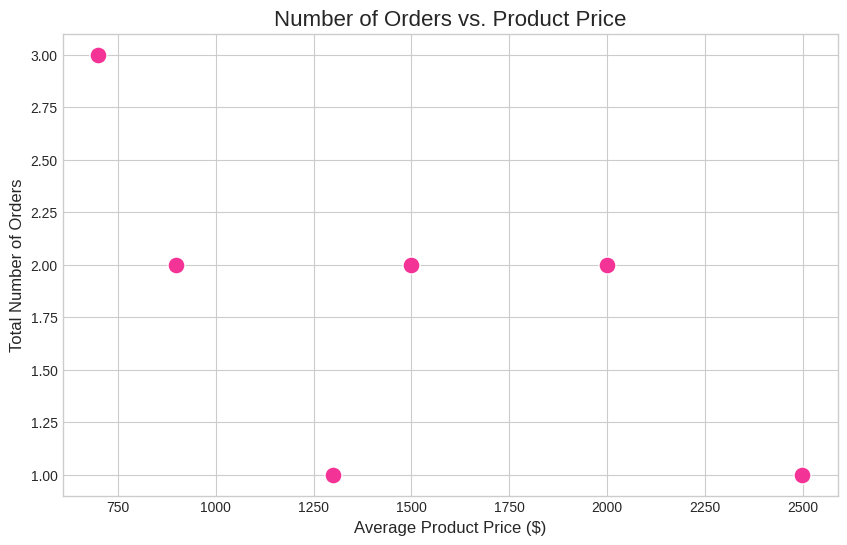

In [3]:
# --- 3. SALES ANALYSIS ---
# =======================================================================

print("\n\n--- Part 1: Sales Analysis ---")

# --- GMV (Gross Merchandise Value) per Product ---
print("\n[Analysis] Calculating GMV per Product...")
gmv_query = '''
    SELECT
        p.name AS product_name,
        SUM(od.price * od.quantity) as GMV
    FROM order_details od
    JOIN products p ON od.product_id = p.id
    GROUP BY product_name
    ORDER BY GMV DESC;
'''
gmv_per_product = run_query1(gmv_query)
print(gmv_per_product)

# --- Number of Orders vs. Product Price ---
print("\n[Analysis] Plotting Number of Orders vs. Product Price...")
orders_v_price_query = '''
    SELECT
        p.name,
        COUNT(od.order_id) as number_of_orders,
        AVG(od.price) as average_price
    FROM products p
    JOIN order_details od ON p.id = od.product_id
    GROUP BY p.name;
'''
orders_v_price_df = run_query1(orders_v_price_query)

# Plotting the graph
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.scatterplot(x="average_price", y="number_of_orders", data=orders_v_price_df, s=150, color='#f43397')
plt.title('Number of Orders vs. Product Price', fontsize=16)
plt.xlabel('Average Product Price ($)', fontsize=12)
plt.ylabel('Total Number of Orders', fontsize=12)
plt.show()


In [4]:
# =======================================================================
# --- 4. CUSTOMER RETENTION ANALYSIS ---
# =======================================================================

print("\n\n--- Part 2: Customer Retention Analysis ---")
print("\n[Analysis] Generating weekly user retention cohorts...")
retention_query = """
WITH user_first_order AS (
    -- Find the first order week for each user to define their cohort
    SELECT
        userId,
        MIN(STRFTIME('%Y-%W', created)) as cohort_week
    FROM orders
    GROUP BY userId
),
order_weeks AS (
    -- Get the activity week for every order
    SELECT
        userId,
        STRFTIME('%Y-%W', created) as order_week
    FROM orders
    GROUP BY 1, 2
)
-- Calculate how many users from each cohort were active in subsequent weeks
SELECT
    ufo.cohort_week,
    ow.order_week,
    COUNT(DISTINCT ufo.userId) as retained_users
FROM user_first_order ufo
JOIN order_weeks ow ON ufo.userId = ow.userId
GROUP BY 1, 2
ORDER BY 1, 2;
"""
retention_data = run_query2(retention_query)
print("Note: Raw retention data below. This can be pivoted to create a retention heatmap.")
print(retention_data)




--- Part 2: Customer Retention Analysis ---

[Analysis] Generating weekly user retention cohorts...
Note: Raw retention data below. This can be pivoted to create a retention heatmap.
   cohort_week order_week  retained_users
0      2025-00    2025-00               2
1      2025-00    2025-01               1
2      2025-00    2025-02               1
3      2025-00    2025-03               1
4      2025-00    2025-05               1
5      2025-00    2025-06               1
6      2025-02    2025-02               1
7      2025-02    2025-04               1
8      2025-03    2025-03               1
9      2025-04    2025-04               1
10     2025-06    2025-06               1


In [5]:
# --- 5. OPERATIONAL ANALYSIS (OTIF) ---
# =======================================================================
print("\n\n--- Part 3: Operational (Shipping) Analysis ---")
print("\n[Analysis] Calculating On-Time In-Full (OTIF) shipping performance...")
otif_query = """
WITH combined_data AS (
    -- Join timeline and shipment tables and extract the relevant dates
    SELECT
        ot.order_id,
        DATE(os.actual_dispatch_date) as dispatch_date,
        DATE(JSON_EXTRACT(ot.message, '$.dispatch_date')) as message_date
    FROM order_timeline ot
    JOIN order_shipment os ON ot.order_id = os.order_id
),
day_diff AS (
    -- Calculate the difference in days between actual and promised dispatch
    SELECT
        order_id,
        JULIANDAY(dispatch_date) - JULIANDAY(message_date) as diff
    FROM combined_data
),
categories AS (
    -- Categorize each order based on the day difference
    SELECT
        CASE
            WHEN diff <= 0      THEN 'Shipped On or Before Promised Date'
            WHEN diff = 1       THEN 'Shipped 1 Day Late'
            WHEN diff = 2       THEN 'Shipped 2 Days Late'
            ELSE 'Shipped >2 Days Late'
        END as shipping_category
    FROM day_diff
)
-- Aggregate the results to get counts and percentages
SELECT
    shipping_category,
    COUNT(*) as order_count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM categories), 2) as percentage
FROM categories
GROUP BY shipping_category;
"""
otif_results = run_query3(otif_query)
print(otif_results)




--- Part 3: Operational (Shipping) Analysis ---

[Analysis] Calculating On-Time In-Full (OTIF) shipping performance...
                    shipping_category  order_count  percentage
0                  Shipped 1 Day Late            1       16.67
1                 Shipped 2 Days Late            1       16.67
2                Shipped >2 Days Late            1       16.67
3  Shipped On or Before Promised Date            3       50.00
